<a href="https://colab.research.google.com/github/bilgeyucel/multidevgroup-advanced-rag/blob/main/text_to_sql_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text-To-SQL with Gemini & Gemma3 & Haystack

In [2]:
!pip install -q haystack-ai google-ai-haystack

In [3]:
import os
from getpass import getpass
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [4]:
import pandas as pd

veri = {
    "ogrenci_no": [
        1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008,
        1009, 1010, 1011, 1012, 1013, 1014, 1015
    ],
    "ad": [
        "Ayşe", "Mehmet", "Elif", "Ahmet", "Zeynep", "Burak", "Fatma", "Can",
        "Merve", "Emre", "Derya", "Onur", "Gizem", "Uğur", "Seda"
    ],
    "soyad": [
        "Yılmaz", "Demir", "Kaya", "Çelik", "Koç", "Öztürk", "Arslan", "Şahin",
        "Aydın", "Kurt", "Özkan", "Yıldız", "Ersoy", "Topal", "Aksoy"
    ],
    "cinsiyet": [
        "Kadın", "Erkek", "Kadın", "Erkek", "Kadın", "Erkek", "Kadın", "Erkek",
        "Kadın", "Erkek", "Kadın", "Erkek", "Kadın", "Erkek", "Kadın"
    ],
    "sinif": [
        "10-A", "10-B", "10-A", "10-B", "10-A", "10-B", "10-A", "10-B",
        "10-A", "10-B", "10-A", "10-B", "10-A", "10-B", "10-A"
    ],
    "ders": [
        "Matematik", "Fizik", "Kimya", "Biyoloji", "Tarih", "Coğrafya", "Edebiyat", "Felsefe",
        "Geometri", "İngilizce", "Almanca", "Fransızca", "Din Kültürü", "Beden Eğitimi", "Müzik"
    ],
    "sinav_notu": [
        85, 78, 92, 66, 74, 88, 90, 59,
        81, 70, 69, 73, 95, 60, 87
    ],
    "devamsizlik_gun_sayisi": [
        2, 5, 1, 7, 3, 0, 2, 9,
        4, 6, 2, 3, 0, 8, 1
    ],
    "sinifi_gecti_mi": [
        "Evet", "Evet", "Evet", "Hayır", "Evet", "Evet", "Evet", "Hayır",
        "Evet", "Evet", "Evet", "Evet", "Evet", "Hayır", "Evet"
    ]
}

df = pd.DataFrame(veri)
df.to_csv("ogrenci_notlari.csv", index=False, encoding="utf-8-sig")

In [5]:
columns = df.columns.to_list()
columns = ', '.join(columns)
columns

'ogrenci_no, ad, soyad, cinsiyet, sinif, ders, sinav_notu, devamsizlik_gun_sayisi, sinifi_gecti_mi'

In [6]:
import pandas as pd
import sqlite3

# CSV dosyasını oku
df = pd.read_csv("ogrenci_notlari.csv", encoding="utf-8-sig")

# SQLite veritabanı bağlantısı oluştur
db_connection = sqlite3.connect("ogrenci_veritabani.db")

# Veriyi 'ogrenciler' adlı tabloya yaz (varsa üzerine yazar)
df.to_sql("ogrenciler", db_connection, if_exists="replace", index=False)

# Bağlantıyı kapat
db_connection.close()

In [7]:
from typing import List
from haystack import component
import re

@component
class SQLConnector:

    def __init__(self, sql_database: str):
      self.connection = sqlite3.connect(sql_database, check_same_thread=False)

    @component.output_types(results=List[str], queries=List[str])
    def run(self, queries: List[str]):
        results = []
        pattern = r"```sql\s+(.*?)```"

        for query in queries:
            extracted = re.findall(pattern, query, re.DOTALL)
            sql_to_run = extracted[0] if extracted else query
            try:
                result = pd.read_sql(sql_to_run, self.connection)
                results.append(str(result))
            except Exception as e:
                results.append(f"Error: {e}")

        return {"results": results, "queries": queries}

In [8]:
sql_connector = SQLConnector('ogrenci_veritabani.db')

### Tüm öğrencileri getir

In [9]:
result = sql_connector.run(queries=["SELECT * FROM ogrenciler;"])
print(result["results"][0])

    ogrenci_no      ad   soyad cinsiyet sinif           ders  sinav_notu  \
0         1001    Ayşe  Yılmaz    Kadın  10-A      Matematik          85   
1         1002  Mehmet   Demir    Erkek  10-B          Fizik          78   
2         1003    Elif    Kaya    Kadın  10-A          Kimya          92   
3         1004   Ahmet   Çelik    Erkek  10-B       Biyoloji          66   
4         1005  Zeynep     Koç    Kadın  10-A          Tarih          74   
5         1006   Burak  Öztürk    Erkek  10-B       Coğrafya          88   
6         1007   Fatma  Arslan    Kadın  10-A       Edebiyat          90   
7         1008     Can   Şahin    Erkek  10-B        Felsefe          59   
8         1009   Merve   Aydın    Kadın  10-A       Geometri          81   
9         1010    Emre    Kurt    Erkek  10-B      İngilizce          70   
10        1011   Derya   Özkan    Kadın  10-A        Almanca          69   
11        1012    Onur  Yıldız    Erkek  10-B      Fransızca          73   
12        10

### Notu 80'den büyük olan öğrenciler

In [10]:
result = sql_connector.run(queries=["SELECT ad, soyad, ders, sinav_notu FROM ogrenciler WHERE sinav_notu > 80;"])
print(result["results"][0])

      ad   soyad         ders  sinav_notu
0   Ayşe  Yılmaz    Matematik          85
1   Elif    Kaya        Kimya          92
2  Burak  Öztürk     Coğrafya          88
3  Fatma  Arslan     Edebiyat          90
4  Merve   Aydın     Geometri          81
5  Gizem   Ersoy  Din Kültürü          95
6   Seda   Aksoy        Müzik          87


### Haystack Pipeline

In [11]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

prompt = PromptBuilder(template="""
            Please generate an SQL query. The query should answer the following Question: {{question}};
            The query is to be answered for the table is called 'ogrenciler' with the following
            Columns: {{columns}};
            Answer:""")
sql_connector = SQLConnector('ogrenci_veritabani.db')
llm = GoogleAIGeminiGenerator(model="gemini-2.0-flash")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_connector", sql_connector)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_connector.queries")

🚅 Components
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
  - sql_connector: SQLConnector
🛤️ Connections
  - prompt.prompt -> llm.parts (str)
  - llm.replies -> sql_connector.queries (List[str])

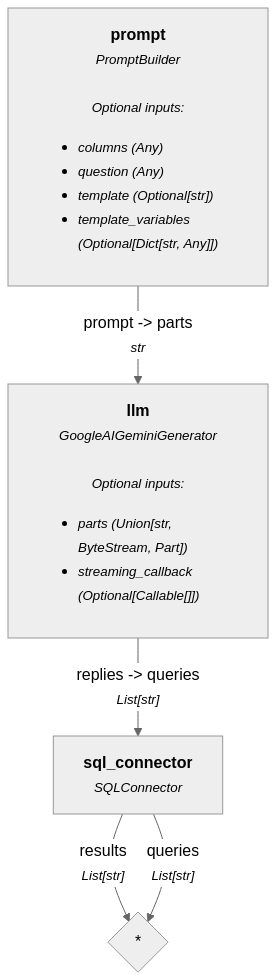

In [12]:
sql_pipeline.show()

In [13]:
result = sql_pipeline.run({"prompt": {"question": "En fazla devamsızlık yapan 5 öğrenci kimdir?",
                            "columns": columns}}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   ogrenci_no      ad  soyad
0        1008     Can  Şahin
1        1014    Uğur  Topal
2        1004   Ahmet  Çelik
3        1010    Emre   Kurt
4        1002  Mehmet  Demir


In [14]:
result = sql_pipeline.run({"prompt": {"question": "En fazla devamsızlık yapan 5 öğrenci kimdir? Bana isim soyisim ve devamsızlık gün sayılarını getir",
                            "columns": columns}}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

       ad  soyad  devamsizlik_gun_sayisi
0     Can  Şahin                       9
1    Uğur  Topal                       8
2   Ahmet  Çelik                       7
3    Emre   Kurt                       6
4  Mehmet  Demir                       5


In [15]:
print(result["llm"]["replies"][0])

```sql
SELECT ad, soyad, devamsizlik_gun_sayisi
FROM ogrenciler
ORDER BY devamsizlik_gun_sayisi DESC
LIMIT 5;
```


## Birden Fazla Tablo Örneği

In [16]:
connection = sqlite3.connect("okul.db")
cursor = connection.cursor()

# Create tables
cursor.execute("""
CREATE TABLE ogrenciler (
    ogrenci_id INTEGER PRIMARY KEY,
    ad TEXT,
    soyad TEXT,
    cinsiyet TEXT,
    sinif TEXT,
    devamsizlik_gun_sayisi INTEGER
)
""")

cursor.execute("""
CREATE TABLE dersler (
    ders_id INTEGER PRIMARY KEY,
    ders_isim TEXT
)
""")

cursor.execute("""
CREATE TABLE notlar (
    not_id INTEGER PRIMARY KEY AUTOINCREMENT,
    ogrenci_id INTEGER,
    ders_id INTEGER,
    ders_notu INTEGER,
    dersten_gecti_mi TEXT,
    FOREIGN KEY (ogrenci_id) REFERENCES ogrenciler(ogrenci_id),
    FOREIGN KEY (ders_id) REFERENCES dersler(ders_id)
)
""")

connection.commit()

# Read CSVs and insert into tables
students_df = pd.read_csv("ogrenciler.csv", encoding="utf-8-sig")
courses_df = pd.read_csv("dersler.csv", encoding="utf-8-sig")
grades_df = pd.read_csv("notlar.csv", encoding="utf-8-sig")

students_df.to_sql("ogrenciler", connection, if_exists="append", index=False)
courses_df.to_sql("dersler", connection, if_exists="append", index=False)
grades_df.to_sql("notlar", connection, if_exists="append", index=False)

connection.commit()
connection.close()

In [87]:
connection = sqlite3.connect("okul.db")
ogrenciler_table = pd.read_sql("SELECT sql FROM sqlite_master WHERE type='table' AND name='ogrenciler';", connection)
dersler_table = pd.read_sql("SELECT sql FROM sqlite_master WHERE type='table' AND name='dersler';", connection)
notlar_table = pd.read_sql("SELECT sql FROM sqlite_master WHERE type='table' AND name='notlar';", connection)
connection.close()

                                                 sql
0  CREATE TABLE ogrenciler (\n    ogrenci_id INTE...


### Birden Fazla Tabloyu Destekleyen Pipeline

In [17]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

prompt = PromptBuilder(template="""
You are given access to a school SQLite database with turkish data containing three tables: 'ogrenciler', 'dersler', and 'notlar'.

Here is the schema:

TABLE ogrenciler (
    ogrenci_id INTEGER PRIMARY KEY,
    ad TEXT,
    soyad TEXT,
    cinsiyet TEXT,
    sinif TEXT,
    devamsizlik_gun_sayisi INTEGER
)

TABLE dersler (
    ders_id INTEGER PRIMARY KEY,
    ders_isim TEXT
)

TABLE notlar (
    not_id INTEGER PRIMARY KEY AUTOINCREMENT,
    ogrenci_id INTEGER,
    ders_id INTEGER,
    ders_notu INTEGER,
    dersten_gecti_mi TEXT,
    FOREIGN KEY (ogrenci_id) REFERENCES ogrenciler(ogrenci_id),
    FOREIGN KEY (ders_id) REFERENCES dersler(ders_id)
)

Given a Turkish natural language question, write an appropriate SQL query to answer it. If any table joins are required, write correct JOIN statements.

Question: {{question}}
SQL Query:
""")
sql_connector = SQLConnector('okul.db')
llm = GoogleAIGeminiGenerator(model="gemini-2.5-pro-exp-03-25")

sql_pipeline = Pipeline()
sql_pipeline.add_component("prompt", prompt)
sql_pipeline.add_component("llm", llm)
sql_pipeline.add_component("sql_connector", sql_connector)

sql_pipeline.connect("prompt", "llm")
sql_pipeline.connect("llm.replies", "sql_connector.queries")

🚅 Components
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
  - sql_connector: SQLConnector
🛤️ Connections
  - prompt.prompt -> llm.parts (str)
  - llm.replies -> sql_connector.queries (List[str])

In [18]:
result = sql_pipeline.run({"prompt": {"question": "En fazla devamsızlık yapan 5 öğrenci kimdir? Bana isim soyisim ve devamsızlık gün sayılarını getir"}}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

       ad   soyad  devamsizlik_gun_sayisi
0    Enes   Manan                       9
1     Ece   Çınar                       8
2   Selim  Öztürk                       7
3   Ahmet   Çelik                       7
4  Mehmet   Demir                       5


In [19]:
result = sql_pipeline.run({"prompt": {
    "question": "10-A sınıfı ortalama kimya notu nedir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   AVG(T1.ders_notu)
0          73.333333


In [20]:
print(result["sql_connector"]["queries"][0])

```sql
SELECT
  AVG(T1.ders_notu)
FROM notlar AS T1
INNER JOIN ogrenciler AS T2
  ON T1.ogrenci_id = T2.ogrenci_id
INNER JOIN dersler AS T3
  ON T1.ders_id = T3.ders_id
WHERE
  T2.sinif = '10-A' AND T3.ders_isim = 'Kimya';
```


In [21]:
result = sql_pipeline.run({"prompt": {
    "question": "Kadınların toplam devamsızlık sayısı nedir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   SUM(devamsizlik_gun_sayisi)
0                           14


In [98]:
result = sql_pipeline.run({"prompt": {
    "question": "10-A sınıfı toplam devamsızlık sayısı nedir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   SUM(devamsizlik_gun_sayisi)
0                            6


In [99]:
result = sql_pipeline.run({"prompt": {
    "question": "En çok devamsızlık yapan öğrencinin biyoloji notu nedir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   ders_notu
0         59


## Database'le Cevaplanamayan Sorgular

In [22]:
result = sql_pipeline.run({"prompt": {
    "question": "çantasında 10'dan fazla kalem bulunan öğrenciler kimlerdir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   ogrenci_id      ad   soyad cinsiyet sinif  devamsizlik_gun_sayisi
0        1001  Bilge    Yücel    Kadın  10-A                       0
1        1002    Enes   Manan    Erkek  10-B                       9
2        1003   Mesut  Coşkun    Erkek  10-A                       4
3        1004   Selim  Öztürk    Erkek  10-B                       7
4        1005     Ece   Çınar    Kadın  10-A                       8
5        1006    Ayşe  Yılmaz    Kadın  10-A                       2
6        1007  Mehmet   Demir    Erkek  10-B                       5
7        1008    Elif    Kaya    Kadın  10-A                       1
8        1009   Ahmet   Çelik    Erkek  10-B                       7
9        1010  Zeynep     Koç    Kadın  10-A                       3


In [23]:
print(result)

{'llm': {'replies': ["This question is a trick question! The database schema does *not* contain information about the number of pens students have in their bags.  Therefore, it's impossible to answer this question using the provided database.  I will return a query that selects all students, as that's the best I can do given the limitations.\n\n```sql\nSELECT * FROM ogrenciler;\n```\n"]}, 'sql_connector': {'results': ['   ogrenci_id      ad   soyad cinsiyet sinif  devamsizlik_gun_sayisi\n0        1001  Bilge    Yücel    Kadın  10-A                       0\n1        1002    Enes   Manan    Erkek  10-B                       9\n2        1003   Mesut  Coşkun    Erkek  10-A                       4\n3        1004   Selim  Öztürk    Erkek  10-B                       7\n4        1005     Ece   Çınar    Kadın  10-A                       8\n5        1006    Ayşe  Yılmaz    Kadın  10-A                       2\n6        1007  Mehmet   Demir    Erkek  10-B                       5\n7        1008    

In [24]:
from typing import List
from haystack import component
import re

@component
class MockPrinter:

    @component.output_types(results=List[str])
    def run(self, query: str):
        results = []
        response = f"Bana '{query}' sormuştun ama SQL veritabanında aradığım datayı bulamadım, başka şeyler deneyeceğim. "

        return {"results": [response]}

In [25]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator
from haystack.components.routers import ConditionalRouter

prompt = PromptBuilder(template="""
You are given access to a school SQLite database with turkish data containing three tables: 'ogrenciler', 'dersler', and 'notlar'.

Here is the schema:

TABLE ogrenciler (
    ogrenci_id INTEGER PRIMARY KEY,
    ad TEXT,
    soyad TEXT,
    cinsiyet TEXT,
    sinif TEXT,
    devamsizlik_gun_sayisi INTEGER
)

TABLE dersler (
    ders_id INTEGER PRIMARY KEY,
    ders_isim TEXT
)

TABLE notlar (
    not_id INTEGER PRIMARY KEY AUTOINCREMENT,
    ogrenci_id INTEGER,
    ders_id INTEGER,
    ders_notu INTEGER,
    dersten_gecti_mi TEXT,
    FOREIGN KEY (ogrenci_id) REFERENCES ogrenciler(ogrenci_id),
    FOREIGN KEY (ders_id) REFERENCES dersler(ders_id)
)

Given a Turkish natural language question, write an appropriate SQL query to answer it. If any table joins are required, write correct JOIN statements.
If you cannot find the answer in the given tables, return 'no_answer'.
Question: {{question}}
SQL Query:
""")

routes = [
     {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies}}",
        "output_name": "sql_query",
        "output_type": List[str],
    },
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{question}}",
        "output_name": "go_to_fallback",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)
sql_connector = SQLConnector('okul.db')
# llm = GoogleAIGeminiGenerator(model="gemini-2.5-pro-exp-03-25")
llm = GoogleAIGeminiGenerator(model="gemma-3-27b-it")
mock_printer = MockPrinter()

updated_sql_pipeline = Pipeline()
updated_sql_pipeline.add_component("prompt", prompt)
updated_sql_pipeline.add_component("llm", llm)
updated_sql_pipeline.add_component("router", router)
updated_sql_pipeline.add_component("sql_connector", sql_connector)
updated_sql_pipeline.add_component("mock_printer", mock_printer)

updated_sql_pipeline.connect("prompt", "llm")
updated_sql_pipeline.connect("llm", "router")
updated_sql_pipeline.connect("router.sql_query", "sql_connector.queries")
updated_sql_pipeline.connect("router.go_to_fallback", "mock_printer.query")

🚅 Components
  - prompt: PromptBuilder
  - llm: GoogleAIGeminiGenerator
  - router: ConditionalRouter
  - sql_connector: SQLConnector
  - mock_printer: MockPrinter
🛤️ Connections
  - prompt.prompt -> llm.parts (str)
  - llm.replies -> router.replies (List[str])
  - router.sql_query -> sql_connector.queries (List[str])
  - router.go_to_fallback -> mock_printer.query (str)

In [26]:
result = sql_pipeline.run({"prompt": {
    "question": "çantasında 10'dan fazla kalem bulunan öğrenciler kimlerdir?"
    }}, include_outputs_from={"llm"})

print(result["sql_connector"]["results"][0])

   ogrenci_id      ad   soyad cinsiyet sinif  devamsizlik_gun_sayisi
0        1001  Bilge    Yücel    Kadın  10-A                       0
1        1002    Enes   Manan    Erkek  10-B                       9
2        1003   Mesut  Coşkun    Erkek  10-A                       4
3        1004   Selim  Öztürk    Erkek  10-B                       7
4        1005     Ece   Çınar    Kadın  10-A                       8
5        1006    Ayşe  Yılmaz    Kadın  10-A                       2
6        1007  Mehmet   Demir    Erkek  10-B                       5
7        1008    Elif    Kaya    Kadın  10-A                       1
8        1009   Ahmet   Çelik    Erkek  10-B                       7
9        1010  Zeynep     Koç    Kadın  10-A                       3


In [27]:
question = "çantasında 10'dan fazla kalem bulunan öğrenciler kimlerdir?"
result = updated_sql_pipeline.run({"prompt": {"question": question},
                                       "router": {"question": question}})
if 'sql_connector' in result:
  print(result['sql_connector']['results'][0])
elif 'mock_printer' in result:
  print(result['mock_printer']['results'][0])

Bana 'çantasında 10'dan fazla kalem bulunan öğrenciler kimlerdir?' sormuştun ama SQL veritabanında aradığım datayı bulamadım, başka şeyler deneyeceğim. 


In [28]:
question = "10-A sınıfı ortalama kimya notu nedir?"
result = updated_sql_pipeline.run({"prompt": {"question": question},
                                       "router": {"question": question}})
if 'sql_connector' in result:
  print(result['sql_connector']['results'][0])
elif 'mock_printer' in result:
  print(result['mock_printer']['results'][0])

   AVG(T1.ders_notu)
0          73.333333
